<a href="https://colab.research.google.com/github/swethankreddy/Regime-Detection-of-Market/blob/main/RozReturnsV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [6]:
import pandas as pd
print(pd.__version__)


2.2.2


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# ------------------ Load Data ------------------ #
trade_df = pd.read_csv('/content/drive/MyDrive/BNBFDUSD_202503142.txt', sep=',')
depth_df = pd.read_csv('/content/drive/MyDrive/BNBFDUSD_20250314.txt', sep=',')

In [9]:
print("trade_df columns:", trade_df.columns.tolist())
print("depth_df columns:", depth_df.columns.tolist())


trade_df columns: ['Time', 'Price', 'Quantity', 'IsMarketMaker', 'NumTrades', 'M']
depth_df columns: ['Time', 'BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19', 'BidPriceL18', 'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16', 'BidQtyL16', 'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14', 'BidPriceL13', 'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11', 'BidQtyL11', 'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9', 'BidPriceL8', 'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6', 'BidQtyL6', 'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4', 'BidPriceL3', 'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1', 'BidQtyL1', 'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2', 'AskPriceL3', 'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5', 'AskQtyL5', 'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7', 'AskPriceL8', 'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskPriceL10', 'AskQtyL10', 'AskPriceL11', 'AskQtyL11', 'AskPriceL12', 'AskQtyL12', 'AskPriceL13', 'AskQtyL13', 'A

In [10]:
# ------------------ Time Conversion ------------------ #
def clean_and_convert_time(df):
    df['Time'] = df['Time'].str.replace(r'\+0530 IST', '', regex=True)
    df['Time'] = pd.to_datetime(df['Time'])
    return df

trade_df = clean_and_convert_time(trade_df)
depth_df = clean_and_convert_time(depth_df)

In [11]:
# ------------------ Add Time Difference ------------------ #
trade_df['time_diff'] = trade_df['Time'].diff().dt.total_seconds()

In [12]:
# ------------------ Check Time Alignment ------------------ #
print('Do they have same timestamps:', trade_df['Time'].equals(depth_df['Time']))
print('Number of intersections:', len(set(trade_df['Time']) & set(depth_df['Time'])))


Do they have same timestamps: False
Number of intersections: 0


In [13]:
# ------------------ Set Time Index ------------------ #
trade_df.set_index('Time', inplace=True)
depth_df.set_index('Time', inplace=True)

In [14]:
# ------------------ Compute Log Returns ------------------ #
trade_df['LogReturn'] = np.log(trade_df['Price']) - np.log(trade_df['Price'].shift(1))
trade_df['SquaredLogReturnPerSecond'] = (trade_df['LogReturn'] ** 2) / (trade_df['time_diff'] + 1e-6)

In [15]:
# ------------------ Classify Trades ------------------ #

# Ensure 'IsMarketMaker' is boolean (convert from float if needed)
trade_df['IsMarketMaker'] = trade_df['IsMarketMaker'].fillna(False).astype(bool)

# Now safely apply bitwise NOT
trade_df['is_buy'] = ~trade_df['IsMarketMaker']
trade_df['is_sell'] = trade_df['IsMarketMaker']


In [16]:
# ------------------ Resample Trade Data ------------------ #
trade_resampled = trade_df.resample('1s').agg({
    'Price': 'ohlc',
    'Quantity': 'sum',
    'IsMarketMaker': 'sum',
    'NumTrades': 'sum',
    'M': 'sum'
})

trade_resampled['all_price'] = trade_df['Price'].resample('1s').agg(list)
trade_resampled['time_diff'] = trade_df['time_diff'].resample('1s').agg(list)
trade_resampled['value_of_trade'] = (trade_df['Price'] * trade_df['Quantity']).resample('1s').agg(list)
trade_resampled['SquaredLogReturnPerSecond'] = trade_df['SquaredLogReturnPerSecond'].resample('1s').agg(list)

In [17]:
# ------------------ Buy/Sell Aggregations ------------------ #
buy_market = trade_df[trade_df['is_buy']].resample('1s').agg({
    'Price': 'mean',
    'Quantity': 'mean'
}).rename(columns={'Price': 'avg_buy_market_price', 'Quantity': 'avg_buy_volume'})

sell_market = trade_df[trade_df['is_sell']].resample('1s').agg({
    'Price': 'mean',
    'Quantity': 'mean'
}).rename(columns={'Price': 'avg_sell_market_price', 'Quantity': 'avg_sell_volume'})

In [18]:
# ------------------ Resample Depth Data ------------------ #
lob_agg_dict = {
    f'{side}PriceL{level}': 'ohlc'
    for side in ['Bid', 'Ask'] for level in range(1, 21)
}
lob_agg_dict.update({
    f'{side}QtyL{level}': 'sum'
    for side in ['Bid', 'Ask'] for level in range(1, 21)
})

depth_resampled = depth_df.resample('1s').agg(lob_agg_dict)

In [19]:
# ------------------ Merge ------------------ #
merged_df = pd.merge(trade_resampled, depth_resampled, on='Time', how='outer')

In [42]:
# ------------------ Feature Engineering ------------------ #
features = pd.DataFrame(index=merged_df.index)
features['avg_price'] = merged_df['all_price'].apply(np.mean)
features['price_var'] = merged_df['all_price'].apply(np.var)
features['avg_time_diff'] = merged_df['time_diff'].apply(np.mean)
features['Trade_duration_variance'] = merged_df['time_diff'].apply(np.var)
features['Interval_observations'] = merged_df['all_price'].apply(len)
features['Value_per_second'] = merged_df['value_of_trade'].apply(sum)
features['Total_squared_log_returns_per_second'] = merged_df['SquaredLogReturnPerSecond'].apply(sum)
features['Squared_log_return_per_second_variance'] = merged_df['SquaredLogReturnPerSecond'].apply(np.var)

features['volatility_10s'] = trade_df['LogReturn'].rolling(window=10).std().resample('1s').last()
features['volatility_30s'] = trade_df['LogReturn'].rolling(window=30).std().resample('1s').last()
features['cumulative_volume_10s'] = trade_df['Quantity'].rolling(window=10).sum().resample('1s').last()
features['cumulative_volume_30s'] = trade_df['Quantity'].rolling(window=30).sum().resample('1s').last()

# ------------------ VWAP Shift ------------------ #
def compute_vwap(price, volume, window):
    vwap = (price * volume).rolling(window=window).sum() / volume.rolling(window=window).sum()
    return vwap
# Compute VWAP and its shift for last 10 seconds and 30 seconds
features['vwap_10s'] = compute_vwap(trade_df['Price'], trade_df['Quantity'], window=10).resample('1s').last()
features['vwap_30s'] = compute_vwap(trade_df['Price'], trade_df['Quantity'], window=30).resample('1s').last()

# Compute VWAP shift (change in VWAP over short windows)
features['vwap_shift_10s'] = features['vwap_10s'].diff().fillna(0)
features['vwap_shift_30s'] = features['vwap_30s'].diff().fillna(0)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:4008: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis

In [43]:
# ----------- OBI Features (using NumPy) ----------- #
def compute_OBI(row, levels):
    bid_qty = np.array([row.get(f'BidQtyL{i}', 0) for i in range(1, levels+1)])
    ask_qty = np.array([row.get(f'AskQtyL{i}', 0) for i in range(1, levels+1)])
    obi = (bid_qty - ask_qty) / (bid_qty + ask_qty + 1e-6)
    return np.mean(obi)

features['avg_OBI_5'] = merged_df.apply(lambda row: compute_OBI(row, 5), axis=1)
features['avg_OBI_10'] = merged_df.apply(lambda row: compute_OBI(row, 10), axis=1)
features['avg_OBI_20'] = merged_df.apply(lambda row: compute_OBI(row, 20), axis=1)


In [44]:
# ----------- Add Buy/Sell Market Stats ----------- #
features = features.join(buy_market).join(sell_market)


In [82]:
# ------------------ Save to CSV ------------------ #
merged_df.to_csv('/content/drive/MyDrive/merged.csv')
features.to_csv('/content/drive/MyDrive/features_with_OBI_market.csv')

In [83]:
# ------------------ Print Sample ------------------ #
print(features.head())

                     avg_price  price_var  avg_time_diff  \
Time                                                       
2025-03-14 00:00:02   579.3900   0.000200            NaN   
2025-03-14 00:00:03   579.3175   0.000219       0.278754   
2025-03-14 00:00:04   579.3850   0.000225       0.256823   
2025-03-14 00:00:05   579.3000   0.000000       0.904137   
2025-03-14 00:00:06        NaN        NaN            NaN   

                     Trade_duration_variance  Interval_observations  \
Time                                                                  
2025-03-14 00:00:02                      NaN                      3   
2025-03-14 00:00:03                 0.223097                      4   
2025-03-14 00:00:04                 0.000168                      2   
2025-03-14 00:00:05                 0.000000                      1   
2025-03-14 00:00:06                      NaN                      0   

                     Value_per_second  Total_squared_log_returns_per_second  \
Ti

In [84]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [87]:
df = pd.read_csv('/content/drive/MyDrive/features_with_OBI_market.csv')

In [88]:
# Convert Time to datetime
df['Time'] = pd.to_datetime(df['Time'])

In [89]:
# Select features for clustering
cluster_data = df[[
    'price_var',
    'Total_squared_log_returns_per_second',
    'Squared_log_return_per_second_variance',
    'avg_time_diff',
    'Interval_observations',
    'Value_per_second',
    'avg_OBI_5',
    'avg_OBI_10',
    'avg_OBI_20',
    'avg_buy_market_price',
    'avg_buy_volume',
    'avg_sell_market_price',
    'avg_sell_volume',
    'volatility_10s',
    'volatility_30s',
    'cumulative_volume_10s',
    'cumulative_volume_30s',
    'vwap_10s',
    'vwap_30s',
]].fillna(0)

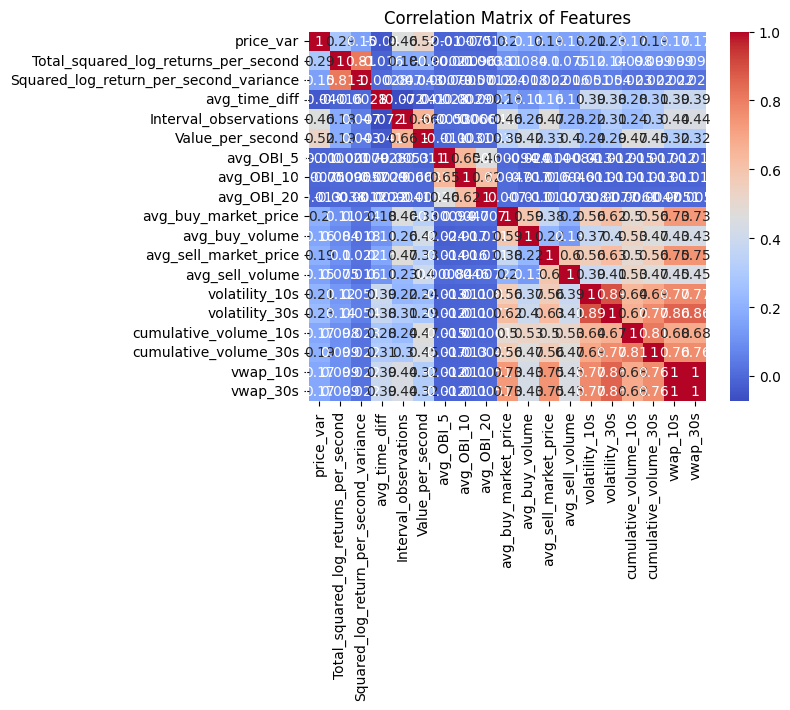

In [90]:
# Check for correlations
correlation_matrix = cluster_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [91]:
# Check for missing data
missing_data = cluster_data.isnull().sum() / len(cluster_data) * 100
print(missing_data[missing_data > 0])  # Show features with missing values



Series([], dtype: float64)


In [92]:
# Scale data
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

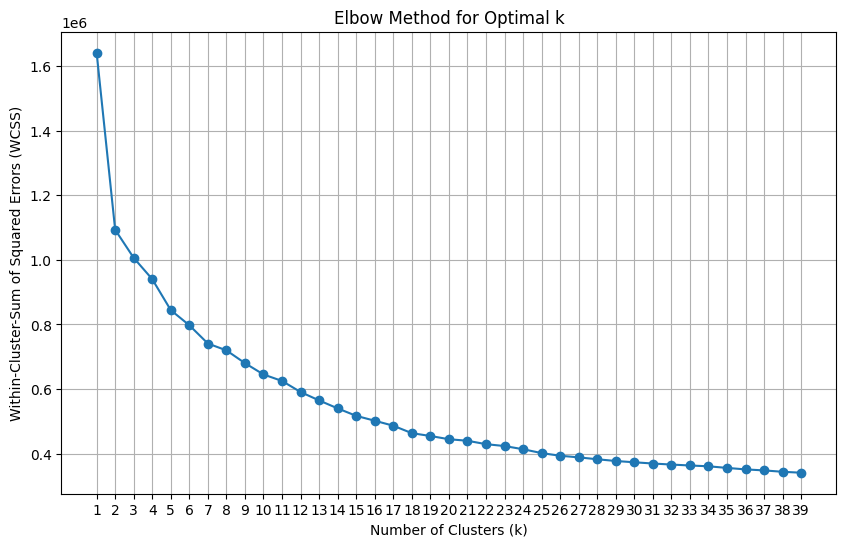

In [93]:
# Elbow method to find optimal number of clusters
wcss = []
K_range = range(1, 40)  # Try from 1 to 20 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = WCSS

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WCSS)')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [94]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_scaled)


In [95]:
# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(cluster_scaled)

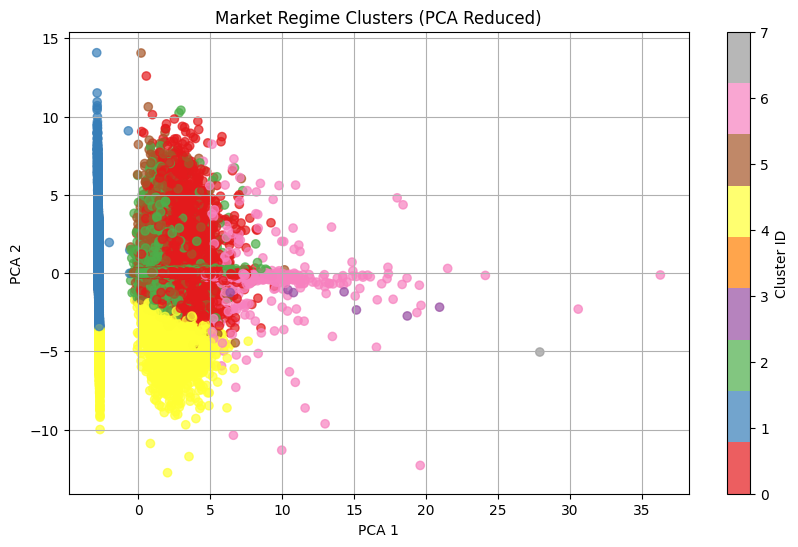

In [96]:
# Scatter plot of clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df['cluster'], cmap='Set1', alpha=0.7)
plt.title('Market Regime Clusters (PCA Reduced)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()

In [97]:
# Drop non-numeric columns for cluster summary and calculate averages
cluster_summary = df.drop(columns=['Time']).groupby('cluster').mean()

In [98]:
# Optional: Normalize for better visualization
cluster_summary_numeric = cluster_summary.select_dtypes(include=[np.number])


In [99]:
# Scale the numeric data for visualization
cluster_summary_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_summary_numeric),
    columns=cluster_summary_numeric.columns,
    index=cluster_summary_numeric.index
)

<ipython-input-101-b5d41ae71c9d>:7: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


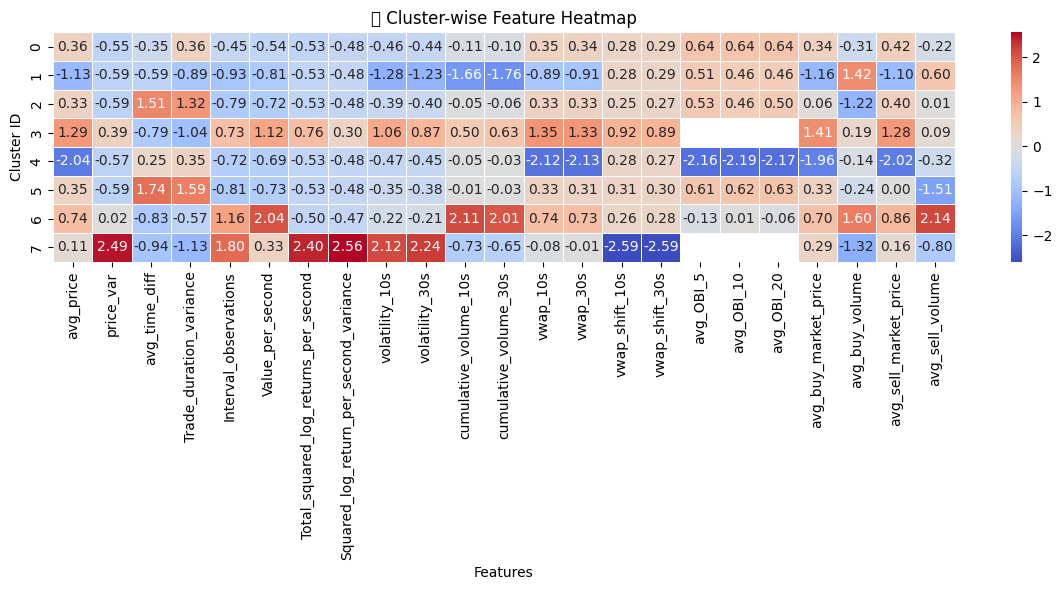

In [101]:
# Plot heatmap of cluster-wise averages
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary_scaled, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('🔥 Cluster-wise Feature Heatmap')
plt.xlabel('Features')
plt.ylabel('Cluster ID')
plt.tight_layout()
plt.show()

